### Stock Market Real-Time Time Series Forecasting project

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Layer
from tensorflow.keras.models import Model, Sequential

In [2]:
# Load Dataset
df = pd.read_csv("stock_dataset.csv")
df

,Date,Open,High,Low,Close,Volume
0,2020-01-01,100.885895,102.793702,99.927116,99.939673,9596
1,2020-01-02,100.082857,100.943242,98.730348,100.042984,8140
2,2020-01-03,100.597039,101.010644,99.013451,100.535108,9785
3,2020-01-04,102.527481,104.415169,102.114482,102.255170,7895
4,2020-01-05,102.209923,102.766476,101.995855,102.187940,5107
...,...,...,...,...,...,...
1495,2024-02-04,168.726602,170.403979,168.555132,168.437731,7026
1496,2024-02-05,170.878241,171.683413,169.725593,170.491307,9472
1497,2024-02-06,171.336851,172.413699,170.119447,173.020009,8970
1498,2024-02-07,173.148882,175.318559,172.680932,171.594886,7818


In [6]:
df.shape

(1500, 6)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1500 non-null   object 
 1   Open    1500 non-null   float64
 2   High    1500 non-null   float64
 3   Low     1500 non-null   float64
 4   Close   1500 non-null   float64
 5   Volume  1500 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 70.4+ KB


In [4]:
df.describe()

,Open,High,Low,Close,Volume
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,115.195974,116.012099,114.405528,115.180164,5497.790000
std,24.042590,24.044590,24.029483,24.041920,2586.314656
min,82.608306,83.504190,81.994257,82.467352,1005.000000
25%,94.478124,95.327850,93.837528,94.314093,3203.750000
50%,104.483777,105.238615,103.882373,104.498722,5521.500000
75%,140.717335,141.764744,140.000650,141.072364,7748.250000
max,173.496691,175.318559,172.680932,173.484511,9998.000000


In [10]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
MA_5      4
MA_10     9
dtype: int64

### Feature Engineering

In [12]:
# Moving Average
df["MA_5"] = df["Close"].rolling(5).mean()
df["MA_10"] = df["Close"].rolling(10).mean()
df.head()

,Date,Open,High,Low,Close,Volume,MA_5,MA_10
0,2020-01-01,100.885895,102.793702,99.927116,99.939673,9596,NaN,NaN
1,2020-01-02,100.082857,100.943242,98.730348,100.042984,8140,NaN,NaN
2,2020-01-03,100.597039,101.010644,99.013451,100.535108,9785,NaN,NaN
3,2020-01-04,102.527481,104.415169,102.114482,102.255170,7895,NaN,NaN
4,2020-01-05,102.209923,102.766476,101.995855,102.187940,5107,100.992175,NaN


In [14]:
# Lag Features
df["Close_Lag1"] = df["Close"].shift(1)
df["Close_Lag2"] = df["Close"].shift(2)
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Volume,MA_5,MA_10,Close_Lag1,Close_Lag2
9,2020-01-10,105.219376,105.690501,105.149844,104.062066,1613,103.628766,102.310471,104.508085,103.614713
10,2020-01-11,103.446349,103.539985,102.259355,103.987833,1868,103.930442,102.715287,104.062066,104.508085
11,2020-01-12,103.454634,104.780431,102.396820,103.774732,1811,103.989486,103.088461,103.987833,104.062066
12,2020-01-13,103.435015,104.722178,102.845903,103.893231,5862,104.045189,103.424274,103.774732,103.987833
13,2020-01-14,100.946877,102.343996,100.011281,102.427235,5177,103.629020,103.441480,103.893231,103.774732


In [15]:
# Select Features
features = ["Open","High","Low","Close","Volume",
            "MA_5","MA_10","Close_Lag1","Close_Lag2"]

data = df[features].values

### Scaling

In [16]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [33]:
# Time Series Sequences

def create_dataset(data, time_step=30):
    x, y = [], []
    for i in range(len(data)-time_step):
        x.append(data[i:i+time_step])
        y.append(data[i+time_step][3])  # Close price
    return np.array(x), np.array(y)

TIME_STEP = 30
x, y = create_dataset(scaled_data, TIME_STEP)

# Train Test Split
split = int(len(x)*0.8)
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

In [35]:
# Baseline Model (Simple LSTM)

baseline_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(TIME_STEP, x.shape[2])),
    Dense(1)])

baseline_model.compile(optimizer="adam", loss="mse")

baseline_model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.1)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0011 - val_loss: 7.8455e-04
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.8190e-04 - val_loss: 6.8343e-04
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.1196e-04 - val_loss: 4.2829e-04
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.5602e-04 - val_loss: 8.5661e-04
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.1726e-04 - val_loss: 3.4453e-04
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.2706e-04 - val_loss: 3.7833e-04
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.0930e-04 - val_loss: 3.9070e-04
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.1907e-04 - val_loss: 5.0198e-04
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.0651e-04 - val_loss: 2.7837e-04
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.8747e-04 - val_loss: 4.2226e-04


In [36]:
# Attention Layer

class AttentionLayer(Layer):
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1],1),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[1],1),
                                 initializer="zeros",
                                 trainable=True)

    def call(self, x):
        e = tf.tanh(tf.matmul(x,self.W)+self.b)
        a = tf.nn.softmax(e, axis=1)
        context = x * a
        return tf.reduce_sum(context, axis=1)

In [37]:
# Attention LSTM Model- (MAIN MODEL)

input_layer = Input(shape=(TIME_STEP, x.shape[2]))
lstm1 = LSTM(64, return_sequences=True)(input_layer)
attention = AttentionLayer()(lstm1)
lstm2 = Dense(32, activation="relu")(attention)
output = Dense(1)(lstm2)

attention_model = Model(inputs=input_layer, outputs=output)

attention_model.compile(optimizer="adam", loss="mse")

attention_model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0064 - val_loss: 0.0013
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 9/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 12/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.5

In [38]:
#  Hyperparameter Tuning (Manual Grid Style)

units_list = [32, 64]
epoch_list = [10, 15]

best_rmse = 999
best_config = None

for units in units_list:
    for ep in epoch_list:

        temp_model = Sequential([
            LSTM(units, input_shape=(TIME_STEP, x.shape[2])),
            Dense(1)])

        temp_model.compile(optimizer="adam", loss="mse")
        temp_model.fit(x_train, y_train, epochs=ep, batch_size=32, verbose=0)

        pred = temp_model.predict(x_test)
        rmse = np.sqrt(mean_squared_error(y_test, pred))

        if rmse < best_rmse:
            best_rmse = rmse
            best_config = (units, ep)

print("Best Config:", best_config)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


C:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


C:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


C:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Best Config: (32, 15)


In [39]:
# Evaluation Function
def evaluate_model(model, x_test, y_test):

    pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mape = np.mean(np.abs((y_test - pred)/y_test))*100

    return pred, mae, rmse, mape

In [41]:
# Evaluate Both Models

base_pred, base_mae, base_rmse, base_mape = evaluate_model(
    baseline_model, x_test, y_test)

att_pred, att_mae, att_rmse, att_mape = evaluate_model(
    attention_model, x_test, y_test)

print("Baseline LSTM")
print("Mean Absolute Percentage Error-(MAPE :",base_mae) 
print("Root Mean Square Error-(RMSE :",base_rmse)
print("Mean Absolute Error-(MAPE):",base_mape)

print("\nAttention LSTM")
print("Mean Absolute Percentage Error-(MAPE :",base_mae) 
print("Root Mean Square Error-(RMSE :",base_rmse)
print("Mean Absolute Error-(MAPE):",base_mape)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Baseline LSTM
Mean Absolute Percentage Error-(MAPE : 0.016046702554213248
Root Mean Square Error-(RMSE : 0.020669835936908555
Mean Absolute Error-(MAPE): 10.894995896285009

Attention LSTM
Mean Absolute Percentage Error-(MAPE : 0.016046702554213248
Root Mean Square Error-(RMSE : 0.020669835936908555
Mean Absolute Error-(MAPE): 10.894995896285009


### Visualization 

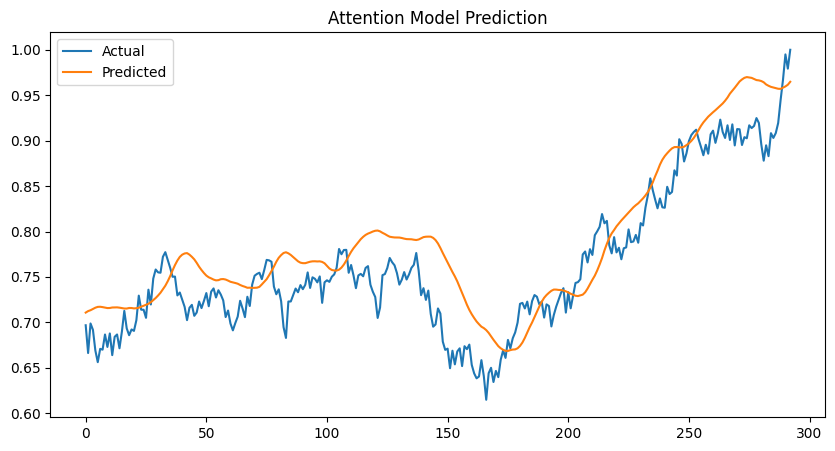

In [42]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual")
plt.plot(att_pred, label="Predicted")
plt.legend()
plt.title("Attention Model Prediction")
plt.show()

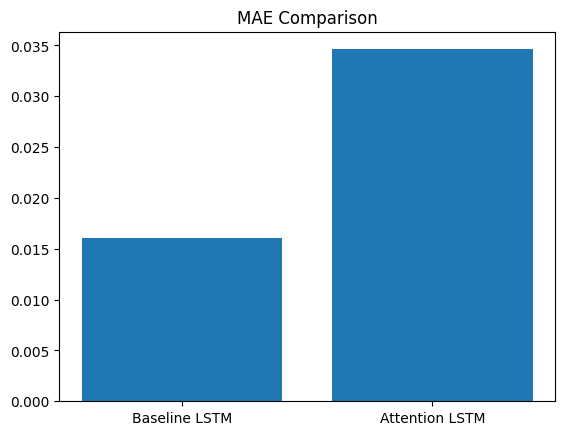

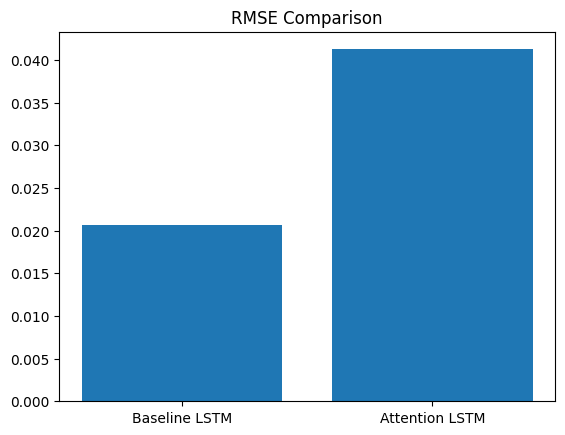

In [43]:
# Error Comparison Graph

models = ["Baseline LSTM","Attention LSTM"]
mae_vals = [base_mae, att_mae]
rmse_vals = [base_rmse, att_rmse]

plt.figure()
plt.bar(models, mae_vals)
plt.title("MAE Comparison")
plt.show()

plt.figure()
plt.bar(models, rmse_vals)
plt.title("RMSE Comparison")
plt.show()